# Evaluation criteria - 

- DB Index: Lower is better.
- Silhouette Score: Higher is better (ranges from -1 to 1).
- Calinski-Harabasz Index: Higher is better.

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [3]:
customers = pd.read_csv('/kaggle/input/dataset/Data/Customers.csv')
transactions = pd.read_csv('/kaggle/input/dataset/Data/Transactions.csv')
products = pd.read_csv('/kaggle/input/dataset/Data/Products.csv')

In [4]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [5]:
data = pd.merge(transactions, customers, on="CustomerID")
data = pd.merge(data, products, on="ProductID")

In [6]:
data.head(10)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68
5,T00442,C0188,P067,2024-12-26 14:40:03,1,300.68,300.68,Anna Ball,South America,2022-05-17,ComfortLiving Bluetooth Speaker,Electronics,300.68
6,T00490,C0195,P067,2024-11-24 11:49:48,3,902.04,300.68,Jeremy Mclaughlin,South America,2024-09-17,ComfortLiving Bluetooth Speaker,Electronics,300.68
7,T00536,C0008,P067,2024-09-22 06:13:59,1,300.68,300.68,David Li,North America,2024-01-13,ComfortLiving Bluetooth Speaker,Electronics,300.68
8,T00564,C0157,P067,2024-12-07 17:57:40,3,902.04,300.68,Miguel Wong,North America,2024-01-30,ComfortLiving Bluetooth Speaker,Electronics,300.68
9,T00631,C0130,P067,2024-05-14 23:14:59,2,601.36,300.68,Robert Jones,South America,2023-04-19,ComfortLiving Bluetooth Speaker,Electronics,300.68


# Feature Engineering

In [7]:
data['TotalSpent'] = data['Quantity'] * data['Price_x']
customer_data = data.groupby('CustomerID').agg({
    'TotalSpent': 'sum',  # Total spending per customer
    'TransactionID': 'count',  # Number of transactions per customer
    'Region': 'first',  # Region of the customer
}).reset_index()

In [8]:
customer_data.rename(columns={'TransactionID': 'NumTransactions'}, inplace=True)


# Encode categorical variables


In [9]:
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_region = encoder.fit_transform(customer_data[['Region']])
encoded_region = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(['Region']))

In [10]:
customer_data = pd.concat([customer_data, encoded_region], axis=1)

In [11]:
customer_data = customer_data.drop(columns=['CustomerID', 'Region'])

# Normalize numerical features


In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data)
customer_data = pd.DataFrame(scaled_features, columns=customer_data.columns)

# Kmeans Clustering

In [13]:
kmeans = KMeans(n_clusters=5, random_state=42)  
customer_data['Cluster'] = kmeans.fit_predict(customer_data)

In [14]:
db_index = davies_bouldin_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
silhouette = silhouette_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
calinski = calinski_harabasz_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])

In [15]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 0.8727201766443912
Silhouette Score: 0.4489488661211377
Calinski-Harabasz Index: 120.87223271819923


In [16]:
kmeans = KMeans(n_clusters=4, random_state=42)  
customer_data['Cluster'] = kmeans.fit_predict(customer_data)

In [17]:
db_index = davies_bouldin_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
silhouette = silhouette_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
calinski = calinski_harabasz_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])

In [18]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 1.0177467299283474
Silhouette Score: 0.37127375842403515
Calinski-Harabasz Index: 83.07590992198917


# Visualization 

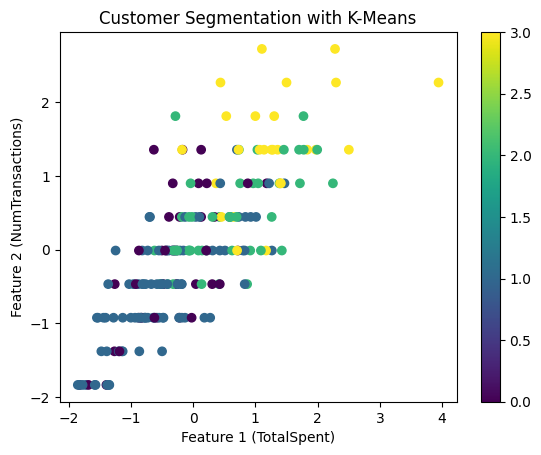

In [19]:
plt.scatter(customer_data.iloc[:, 0], customer_data.iloc[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar()
plt.title("Customer Segmentation with K-Means")
plt.xlabel("Feature 1 (TotalSpent)")
plt.ylabel("Feature 2 (NumTransactions)")
plt.show()

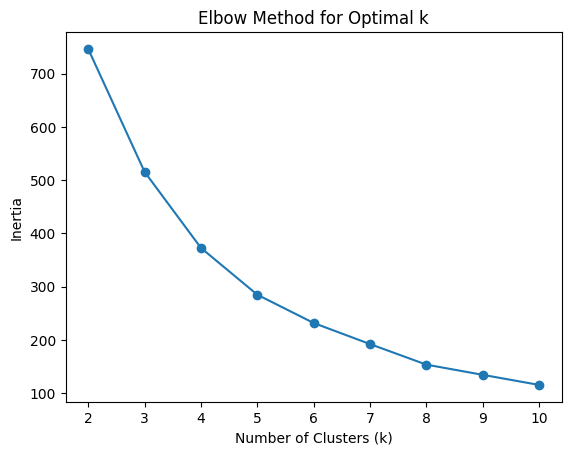

In [20]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data.drop(columns=['Cluster']))
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Improving Model

In [21]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_data.drop(columns=['Cluster']))

    silhouette_avg = silhouette_score(customer_data.drop(columns=['Cluster']), cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}.")

For n_clusters = 2, the average silhouette score is 0.25691894261708625.
For n_clusters = 3, the average silhouette score is 0.4137659892715167.
For n_clusters = 4, the average silhouette score is 0.415019351858285.
For n_clusters = 5, the average silhouette score is 0.4489488661211377.
For n_clusters = 6, the average silhouette score is 0.4548233053963051.
For n_clusters = 7, the average silhouette score is 0.45959924063202817.
For n_clusters = 8, the average silhouette score is 0.47242327409137813.
For n_clusters = 9, the average silhouette score is 0.47743371670986817.
For n_clusters = 10, the average silhouette score is 0.47310322038946717.


> For n_clusters = 9, the average silhouette score is 0.47743371670986817.


In [22]:
# K-Means Clustering
kmeans = KMeans(n_clusters=9, random_state=42)  
customer_data['Cluster'] = kmeans.fit_predict(customer_data)

In [23]:
db_index = davies_bouldin_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
silhouette = silhouette_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
calinski = calinski_harabasz_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 0.7272218941199452
Silhouette Score: 0.4587302063222381
Calinski-Harabasz Index: 145.54674502151644


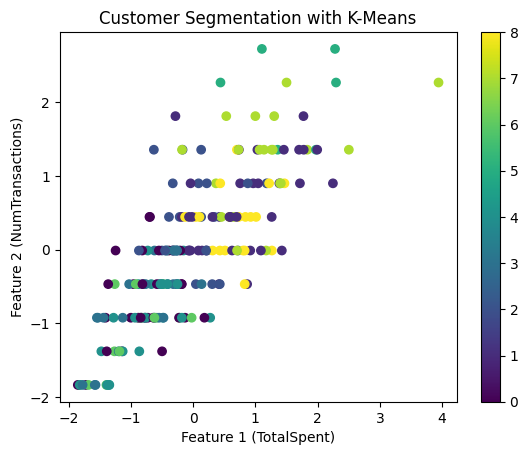

In [24]:
plt.scatter(customer_data.iloc[:, 0], customer_data.iloc[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar()
plt.title("Customer Segmentation with K-Means")
plt.xlabel("Feature 1 (TotalSpent)")
plt.ylabel("Feature 2 (NumTransactions)")
plt.show()

> Accuracy Increased with 9 clusters 

# LetsTry DBSCAN

In [25]:
# dbscan = DBSCAN(eps=0.65, min_samples=5)  
# customer_data['Cluster'] = dbscan.fit_predict(customer_data)

In [26]:
db_index = davies_bouldin_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
silhouette = silhouette_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
calinski = calinski_harabasz_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])

In [27]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 0.7272218941199452
Silhouette Score: 0.4587302063222381
Calinski-Harabasz Index: 145.54674502151644


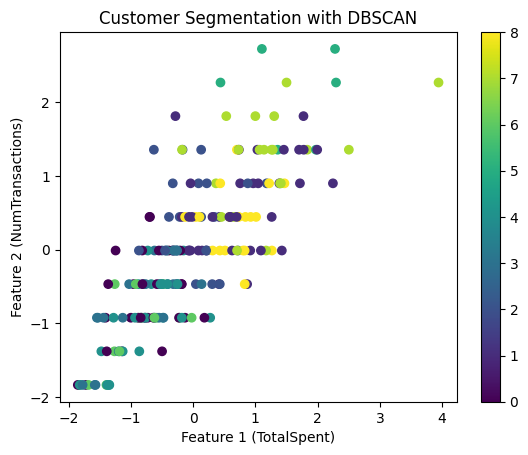

In [28]:
plt.scatter(customer_data.iloc[:, 0], customer_data.iloc[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar()
plt.title("Customer Segmentation with DBSCAN")
plt.xlabel("Feature 1 (TotalSpent)")
plt.ylabel("Feature 2 (NumTransactions)")
plt.show()

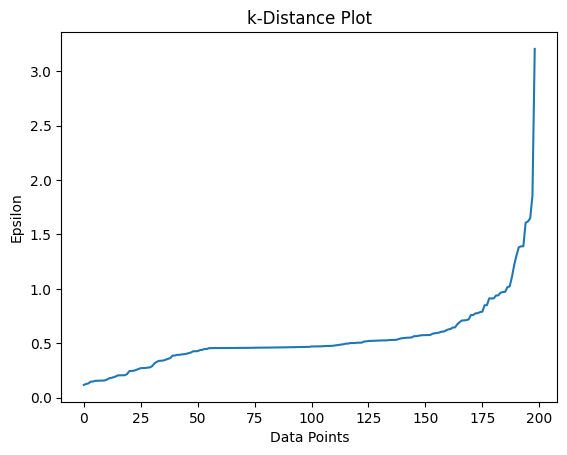

In [29]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(customer_data)
distances, indices = neighbors_fit.kneighbors(customer_data)

distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Epsilon')
plt.title('k-Distance Plot')
plt.show()

> Still K-measn is better than dbscan.

# Improving K-means

In [30]:
customers = pd.read_csv('/kaggle/input/dataset/Data/Customers.csv')
transactions = pd.read_csv('/kaggle/input/dataset/Data/Transactions.csv')
products = pd.read_csv('/kaggle/input/dataset/Data/Products.csv')

In [31]:
from datetime import datetime
data['CustomerTenure'] = (datetime.now() - data['SignupDate']).dt.days

In [32]:
data['TotalSpent'] = data['Quantity'] * data['Price_x']
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

In [33]:
customer_features = data.groupby('CustomerID').agg({
    'TotalSpent': ['sum', 'mean', 'std'],  # Spending patterns
    'TransactionID': 'count',  # Transaction frequency
    'Quantity': ['sum', 'mean'],  # Purchase volume
    'TransactionDate': lambda x: (x.max() - x.min()).days,  # Customer lifetime
    'Region': 'first',
    'ProductID': 'nunique'  # Product variety
}).reset_index()


In [34]:
customer_features.columns = ['CustomerID', 'TotalSpent', 'AvgTransactionValue', 
                           'SpendingStd', 'NumTransactions', 'TotalItems', 
                           'AvgItemsPerTransaction', 'CustomerLifetime', 
                           'Region', 'UniqueProducts']

In [35]:
customer_features['PurchaseFrequency'] = customer_features['NumTransactions'] / customer_features['CustomerLifetime']
customer_features['AvgSpendPerDay'] = customer_features['TotalSpent'] / customer_features['CustomerLifetime']

In [36]:
customer_features = customer_features.replace([np.inf, -np.inf], np.nan)
customer_features = customer_features.fillna(0)

In [37]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_region = encoder.fit_transform(customer_features[['Region']])
encoded_region = pd.DataFrame(encoded_region, 
                            columns=encoder.get_feature_names_out(['Region']))

In [38]:
customer_features = pd.concat([customer_features, encoded_region], axis=1)
features_for_clustering = customer_features.drop(columns=['CustomerID', 'Region'])

In [39]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)
scaled_features_df = pd.DataFrame(scaled_features, 
                                columns=features_for_clustering.columns)

In [40]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_df)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features_df, kmeans.labels_))

In [41]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features_df)

In [42]:
cluster_profiles = customer_features.groupby('Cluster').agg({
    'TotalSpent': 'mean',
    'NumTransactions': 'mean',
    'AvgTransactionValue': 'mean',
    'UniqueProducts': 'mean',
    'PurchaseFrequency': 'mean',
    'CustomerLifetime': 'mean'
}).round(2)

In [43]:
def plot_elbow_curve():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow curve
    ax1.plot(k_range, inertias, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal k')
    
    # Silhouette scores
    ax2.plot(k_range, silhouette_scores, 'rx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs k')
    
    plt.tight_layout()
    plt.show()

In [44]:
def plot_cluster_characteristics():
    # Radar chart of cluster characteristics
    cluster_profiles_normalized = cluster_profiles.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    categories = list(cluster_profiles_normalized.columns)
    num_vars = len(categories)
    
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for cluster in range(optimal_k):
        values = cluster_profiles_normalized.iloc[cluster].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title("Cluster Characteristics")
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

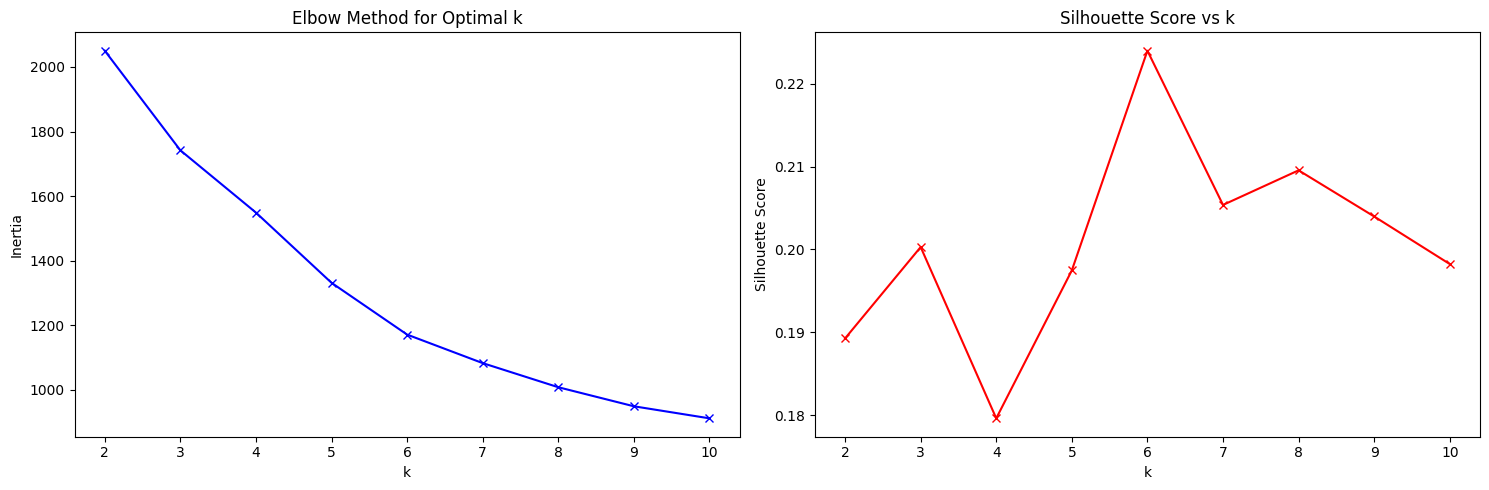

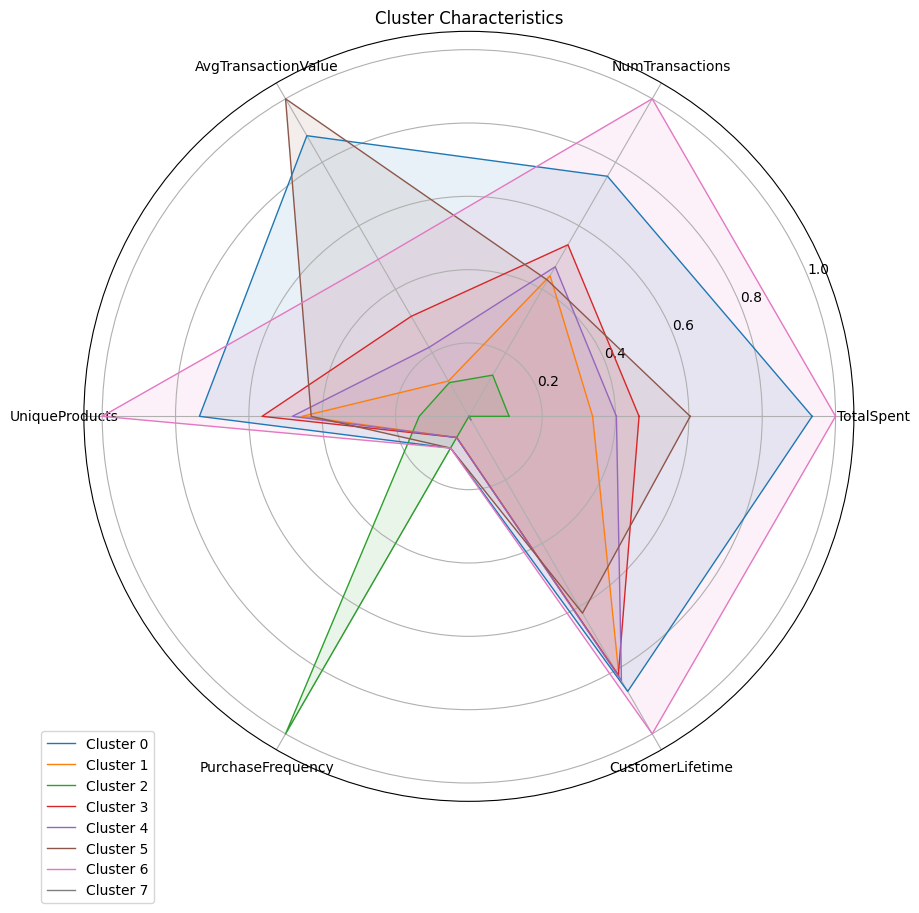

In [45]:
plot_elbow_curve()
plot_cluster_characteristics()

In [46]:
print("\nCluster Evaluation Metrics:")
print(f"Davies-Bouldin Index: {davies_bouldin_score(scaled_features_df, customer_features['Cluster']):.3f}")
print(f"Silhouette Score: {silhouette_score(scaled_features_df, customer_features['Cluster']):.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(scaled_features_df, customer_features['Cluster']):.3f}")


Cluster Evaluation Metrics:
Davies-Bouldin Index: 1.414
Silhouette Score: 0.210
Calinski-Harabasz Index: 42.707


In [47]:
cluster_profiles

,TotalSpent,NumTransactions,AvgTransactionValue,UniqueProducts,PurchaseFrequency,CustomerLifetime
Cluster,,,,,,
0,5422.51,6.44,863.91,6.07,0.03,252.52
1,2304.50,4.22,561.15,4.17,0.02,239.14
2,1118.25,2.00,559.13,2.00,0.30,7.50
3,2964.01,4.91,640.92,4.91,0.02,238.06
4,2642.19,4.42,602.64,4.35,0.02,242.84
5,3690.77,4.12,909.48,4.00,0.03,182.81
6,5754.36,8.17,711.20,7.87,0.03,290.33
7,547.24,1.08,517.50,1.08,0.00,10.62
